# Loading and visualoizing iris data

In [44]:
import numpy as np
import seaborn as sns
iris = sns.load_dataset("iris")
iris.head(n=10)

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
5           5.4          3.9           1.7          0.4  setosa
6           4.6          3.4           1.4          0.3  setosa
7           5.0          3.4           1.5          0.2  setosa
8           4.4          2.9           1.4          0.2  setosa
9           4.9          3.1           1.5          0.1  setosa

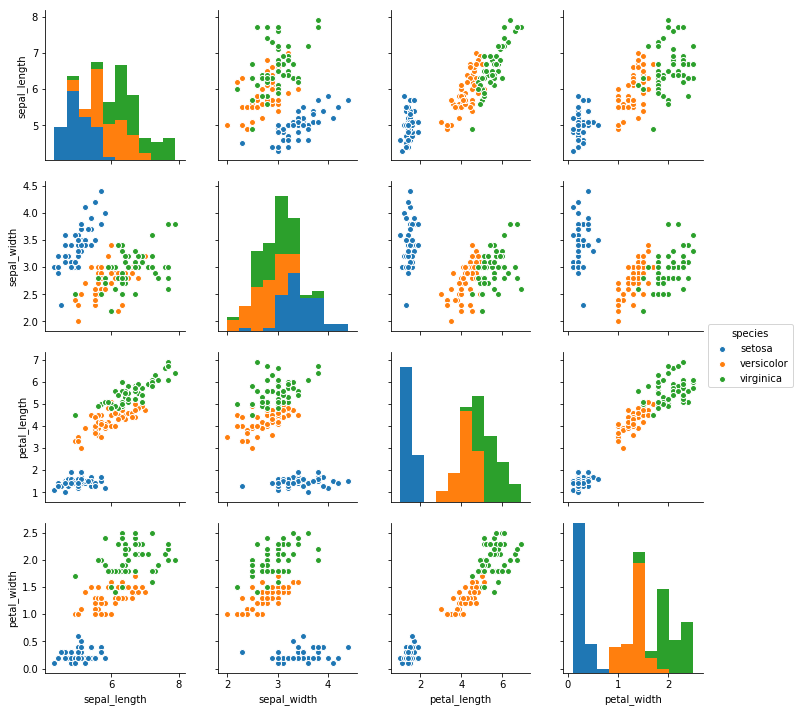

In [11]:
g = sns.pairplot(iris, hue='species')

In [45]:
target_names = iris.species.unique()
iris  = iris.replace({'species' : dict(zip(target_names, [0,1,2]))})
iris.head()

sepal_length  sepal_width  petal_length  petal_width  species
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

In [4]:
target   = 'species'
features = iris.columns.drop(target)
print("features : {} \ntarget   : {}".format(features, target))

features : Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object') 
target   : species


In [20]:
def entropy(X):
    probs = np.bincount(X) / X.size
    probs = probs[probs>0]
    log_probs = np.log2(probs)
    return -np.sum(probs * log_probs)

species_entropy = entropy(iris[target])
print("Entropy of the target is {}".format(species_entropy))

Entropy of the target is 1.584962500721156


In [8]:
def eval_bp(feature,target,bp):
    y1 = target[feature <= bp]
    y2 = target[feature > bp]
    return entropy(y1) + entropy(y2)

entropy_t = eval_bp(iris.petal_length, iris.species, 2.5)
print("Entropy after split is {}".format(entropy_t))

Entropy after split is 1.0


In [22]:
def get_best_split_feature(feature, target, target_entropy=None):

    if target_entropy is None:
        target_entropy = entropy(target)

    min_entropy = target_entropy
    best_bp = None

    # break_points = np.percentile(feature, [20,40,60,80])
    break_points = np.linspace(feature.min(), feature.max(), 10)
    for bp in break_points:
        e = eval_bp(feature, target, bp)
        #print("\t {} :: {}".format(bp, e))
        if e < min_entropy:
            min_entropy = e
            best_bp = bp

    return (min_entropy, best_bp)

entropy_t = get_best_split_feature(iris.petal_width, iris.species, entropy(iris.species))
print(entropy_t)

(1.0, 0.6333333333333333)


In [24]:
def get_best_split(data, features, target):
    target_entropy = entropy(data[target])
    best_feature, best_bp, min_entropy = None, None, target_entropy

    #print("Original Entropy : {}".format(target_entropy))

    for feature in features:
        #print("Evaluating {}".format(feature))
        e,bp = get_best_split_feature(data[feature], data[target],
            target_entropy)
        if (bp is not None) and ( e < min_entropy):
            min_entropy = e
            best_feature = feature
            best_bp = bp

    return (best_feature, best_bp, min_entropy)

Node = get_best_split(iris, features, target)
print(Node)

('petal_length', 2.3111111111111109, 1.0)


In [30]:
def build_tree_(data, features, target, tree):

    Node = get_best_split(data, features, target)

    f,bp,e_  = Node
    if f:
        tree.append(Node)
        ixl = data[f] <= bp
        ixr = data[f] > bp

        left_data  = data.loc[data[f] <= bp,:]
        right_data = data.loc[data[f] > bp,:]

        classes = left_data[target].unique()
        n_classes = len(classes)
        if n_classes > 1:
            build_tree_(left_data, features, target, tree)
        else:
            tree.append((None,None,classes[0]))

        classes = right_data[target].unique()
        n_classes = len(classes)
        if n_classes > 1:
            build_tree_(right_data, features, target, tree)
        else:
            tree.append((None,None,classes[0]))
    else:
        tree.append((Node,Node,data[target].mode()[0]))

    return tree

def train_decision_tree(data, features, target):
    tree = build_tree_(data, features, target, [])
    return tree

tree = train_decision_tree(iris, features, target)
print(tree)

[('petal_length', 2.3111111111111109, 1.0), (None, None, 0), ('petal_width', 1.6666666666666665, 0.64112585646244113), ('petal_length', 5.177777777777778, 0.24229218908241482), ((None, None, 0.24229218908241482), (None, None, 0.24229218908241482), 1), (None, None, 2), ((None, None, 0.24988229283318544), (None, None, 0.24988229283318544), 2)]


In [31]:
[print(node) for node in tree]

('petal_length', 2.3111111111111109, 1.0)
(None, None, 0)
('petal_width', 1.6666666666666665, 0.64112585646244113)
('petal_length', 5.177777777777778, 0.24229218908241482)
((None, None, 0.24229218908241482), (None, None, 0.24229218908241482), 1)
(None, None, 2)
((None, None, 0.24988229283318544), (None, None, 0.24988229283318544), 2)


[None, None, None, None, None, None, None]

In [33]:
def predict(tree, data):

    index = 0
    cond = True
    r = None
    while cond:
        node = tree[index]
        f,bp,e_ = node
        if f is None:
            # leaf Node
            cond = False
            r = e_
        else:
            if data[f] <= bp:
                index += 1
            else:
                index += 2

    return r

print(iris.loc[134,:])
yhat = predict(tree, iris.loc[134,:])
print("pridiction: {}".format(yhat))

sepal_length    6.1
sepal_width     2.6
petal_length    5.6
petal_width     1.4
species         2.0
Name: 134, dtype: float64
pridiction: 2


In [37]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(iris[features], iris[target])

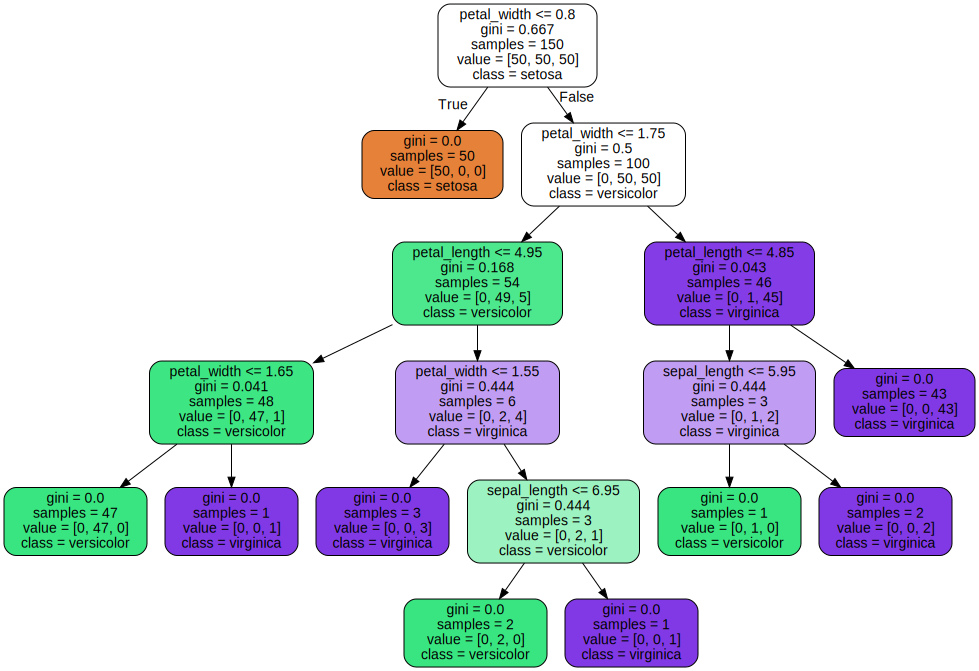

In [46]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=target_names, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph